In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix , plot_confusion_matrix , plot_roc_curve
from imblearn.over_sampling import SMOTE , RandomOverSampler

In [56]:
def eval_classification(y_true , y_pred):
    from sklearn.metrics import accuracy_score , precision_score , f1_score , recall_score
    
    accuracy = accuracy_score(y_true , y_pred)
    precision = precision_score(y_true , y_pred)
    f1 = f1_score(y_true , y_pred)
    recall = recall_score(y_true , y_pred)
    
    score_dict = {'Accuracy' : accuracy,
                  'Precision' : precision,
                  'F1 Score' : f1,
                  'Recall' : recall}
    
    return score_dict

In [57]:
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')

In [58]:
df_payment = pd.read_csv('Dataset/payment_data.csv')
df_payment.head()

,id,OVD_t1,OVD_t2,OVD_t3,OVD_sum,pay_normal,prod_code,prod_limit,update_date,new_balance,highest_balance,report_date
0,58987402,0,0,0,0,1,10,16500.0,04/12/2016,0.0,NaN,NaN
1,58995151,0,0,0,0,1,5,NaN,04/12/2016,588720.0,491100.0,NaN
2,58997200,0,0,0,0,2,5,NaN,04/12/2016,840000.0,700500.0,22/04/2016
3,54988608,0,0,0,0,3,10,37400.0,03/12/2016,8425.2,7520.0,25/04/2016
4,54987763,0,0,0,0,2,10,NaN,03/12/2016,15147.6,NaN,26/04/2016


In [59]:
df_customer = pd.read_csv('Dataset/customer_data.csv')
df_customer.head()

,label,id,fea_1,fea_2,fea_3,fea_4,fea_5,fea_6,fea_7,fea_8,fea_9,fea_10,fea_11
0,1,54982665,5,1245.5,3,77000.0,2,15,5,109,5,151300,244.948974
1,0,59004779,4,1277.0,1,113000.0,2,8,-1,100,3,341759,207.173840
2,0,58990862,7,1298.0,1,110000.0,2,11,-1,101,5,72001,1.000000
3,1,58995168,7,1335.5,1,151000.0,2,11,5,110,3,60084,1.000000
4,0,54987320,7,NaN,2,59000.0,2,11,5,108,4,450081,197.403141


# 1.0 Data Overview
___

In [60]:
print(f'Shape of Payment DF: {df_payment.shape}')
print(f'Size of Payment DF: {df_payment.size}')
print(f'Shape of Customer DF: {df_customer.shape}')
print(f'Size of Customer DF: {df_customer.size}')

Shape of Payment DF: (8250, 12)
Size of Payment DF: 99000
Shape of Customer DF: (1125, 13)
Size of Customer DF: 14625


In [61]:
df_customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1125 entries, 0 to 1124
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   label   1125 non-null   int64  
 1   id      1125 non-null   int64  
 2   fea_1   1125 non-null   int64  
 3   fea_2   976 non-null    float64
 4   fea_3   1125 non-null   int64  
 5   fea_4   1125 non-null   float64
 6   fea_5   1125 non-null   int64  
 7   fea_6   1125 non-null   int64  
 8   fea_7   1125 non-null   int64  
 9   fea_8   1125 non-null   int64  
 10  fea_9   1125 non-null   int64  
 11  fea_10  1125 non-null   int64  
 12  fea_11  1125 non-null   float64
dtypes: float64(3), int64(10)
memory usage: 114.4 KB


In [62]:
df_payment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8250 entries, 0 to 8249
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               8250 non-null   int64  
 1   OVD_t1           8250 non-null   int64  
 2   OVD_t2           8250 non-null   int64  
 3   OVD_t3           8250 non-null   int64  
 4   OVD_sum          8250 non-null   int64  
 5   pay_normal       8250 non-null   int64  
 6   prod_code        8250 non-null   int64  
 7   prod_limit       2132 non-null   float64
 8   update_date      8224 non-null   object 
 9   new_balance      8250 non-null   float64
 10  highest_balance  7841 non-null   float64
 11  report_date      7136 non-null   object 
dtypes: float64(3), int64(7), object(2)
memory usage: 773.6+ KB


# 1.1 Checking for Null
___

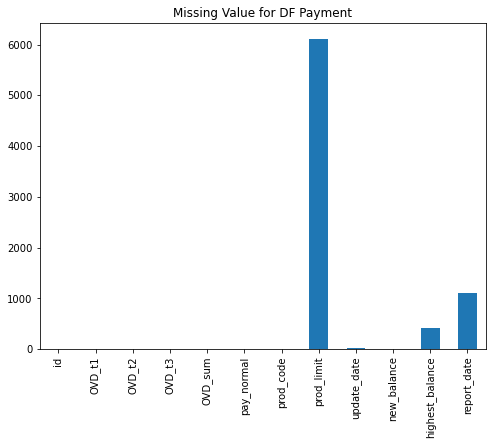

In [63]:
df_payment.isnull().sum().plot(kind = 'bar' , figsize = (8,6))
plt.title('Missing Value for DF Payment');

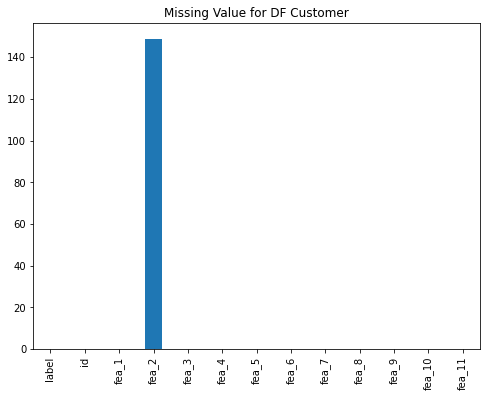

In [64]:
df_customer.isnull().sum().plot(kind = 'bar' , figsize = (8,6))
plt.title('Missing Value for DF Customer');

In [65]:
df_customer['fea_2'].fillna(value = df_customer['fea_2'].median() , inplace=True)

# 1.2 No. of Unique Customer
___
There are 849 unique customer ID in the payment DF, but there are 1125 unique customer ID in customer DF.

In [66]:
print(f'There are {len(df_payment["id"].unique())} unique customer in Payment DF')
print(f'There are {len(df_customer["id"].unique())} unique customer in Customer DF')

There are 1125 unique customer in Payment DF
There are 1125 unique customer in Customer DF


In [67]:
df_customer['id'] = df_customer['id'].astype('category')

# 1.3 Checking Data in DF Payment
___

In [68]:
countable_feature = ['OVD_t1' , 'OVD_t2' , 'OVD_t3' , 'pay_normal']

### 1.3.1 Most Popular Product
___

 - Product #10 has the highest overdue for type 1 to 3 , as well as overdue days
 - Product #6 is the 2nd popular card , however the overdue rate is not as high as product #10 (1st pop) and product #5 (3rd popular). Can look further into the profile of user in this group

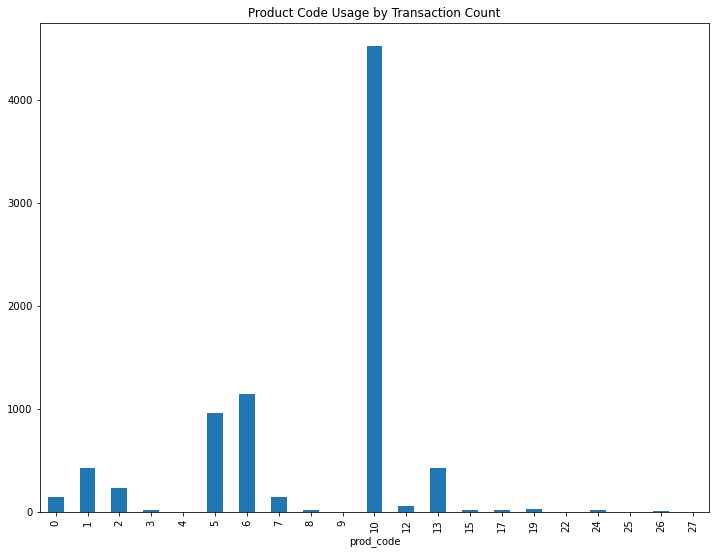

In [69]:
df_payment.groupby('prod_code').count()['id'].plot(kind = 'bar' , figsize = (12,9))
plt.title('Product Code Usage by Transaction Count');

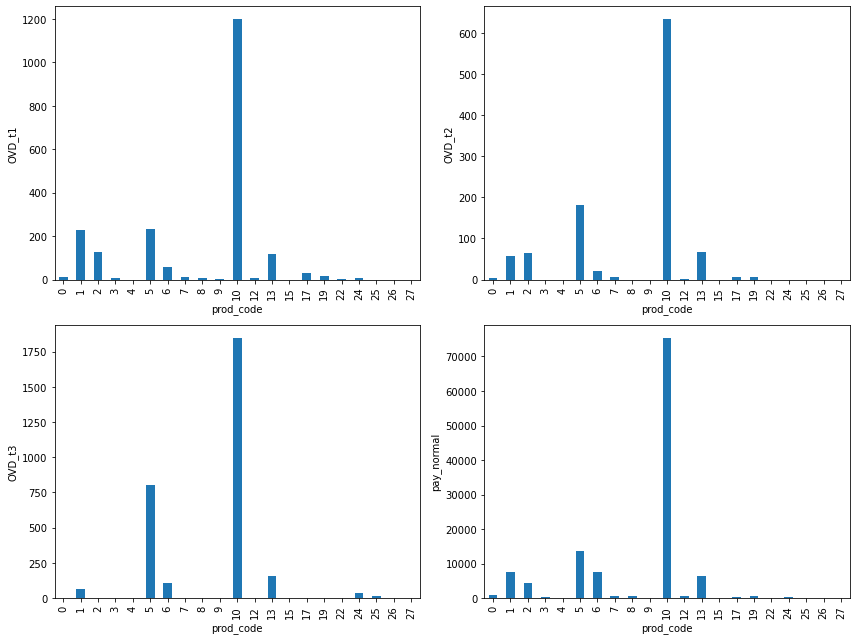

In [70]:
# Product that has the highest overdue rate
fig , ax = plt.subplots(2,2,figsize = (9,9))

ax = ax.ravel()

temp_df = df_payment.groupby('prod_code').count()

for index , column in enumerate(countable_feature):
    plt.subplot(2,2,index+1)
    df_payment.groupby('prod_code').sum()[column].plot(kind = 'bar' , figsize = (12,9))
    plt.ylabel(column)
    
plt.tight_layout()

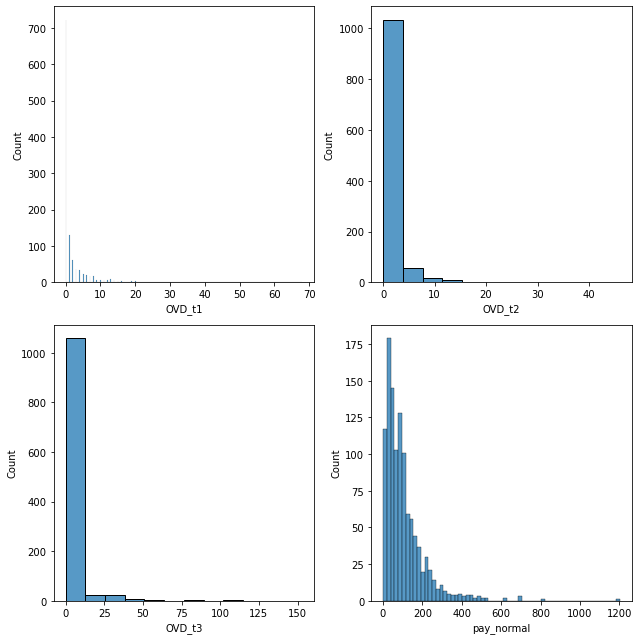

In [71]:
fig , ax = plt.subplots(2,2,figsize = (9,9))

ax = ax.ravel()

temp_df = df_payment.groupby('id').sum()

for index , column in enumerate(countable_feature):
    sns.histplot(x = temp_df[column],
                 data = temp_df,
                 ax = ax[index])
    
plt.tight_layout()

In [72]:
# Imbalance dataset for risky and non-risky users
df_customer['label'].value_counts(normalize = True)

0    0.8
1    0.2
Name: label, dtype: float64

# 1.4 Checking data in DF Customer
___

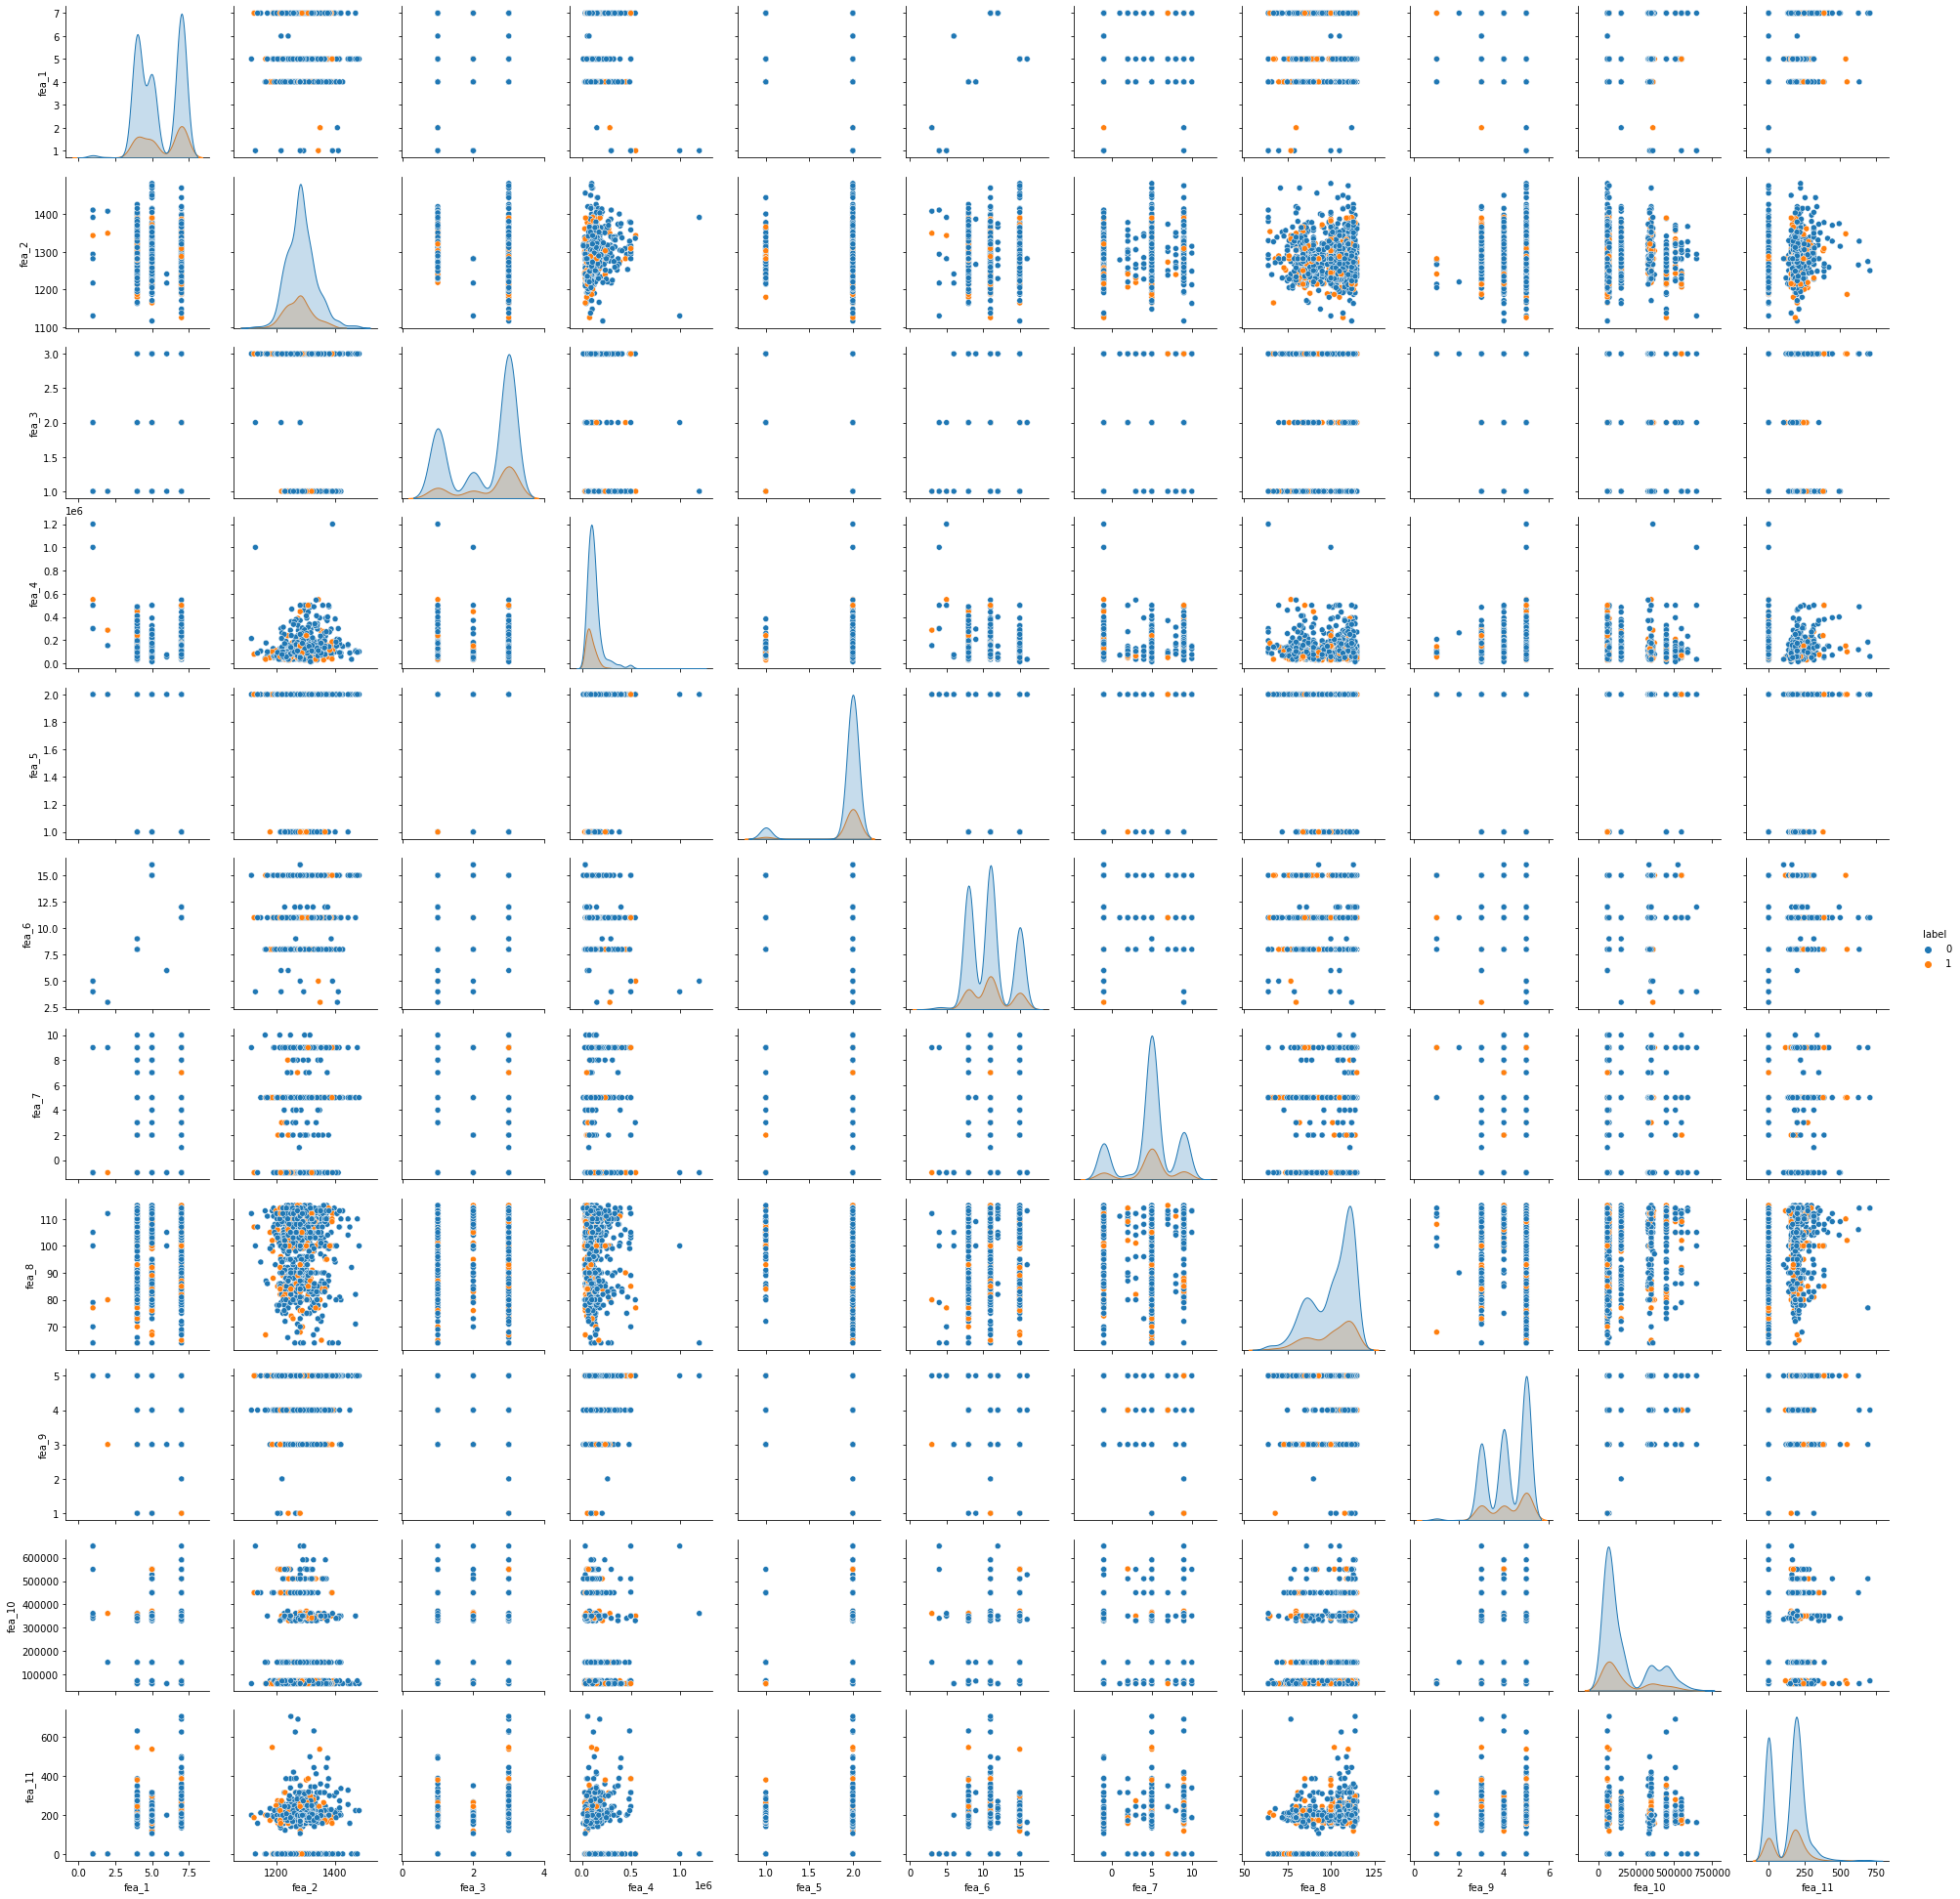

In [73]:
sns.pairplot(df_customer , hue = 'label');

In [74]:
cat_feature = ['fea_1' , 'fea_3' , 'fea_5' , 'fea_6' , 'fea_7' , 'fea_9']

In [75]:
df_customer[cat_feature] = df_customer[cat_feature].astype('category')

In [76]:
df_customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1125 entries, 0 to 1124
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   label   1125 non-null   int64   
 1   id      1125 non-null   category
 2   fea_1   1125 non-null   category
 3   fea_2   1125 non-null   float64 
 4   fea_3   1125 non-null   category
 5   fea_4   1125 non-null   float64 
 6   fea_5   1125 non-null   category
 7   fea_6   1125 non-null   category
 8   fea_7   1125 non-null   category
 9   fea_8   1125 non-null   int64   
 10  fea_9   1125 non-null   category
 11  fea_10  1125 non-null   int64   
 12  fea_11  1125 non-null   float64 
dtypes: category(7), float64(3), int64(3)
memory usage: 111.8 KB


# 1.5 Merging Dataset
___

In [77]:
df_payment.columns

Index(['id', 'OVD_t1', 'OVD_t2', 'OVD_t3', 'OVD_sum', 'pay_normal',
       'prod_code', 'prod_limit', 'update_date', 'new_balance',
       'highest_balance', 'report_date'],
      dtype='object')

In [78]:
agg_dict = {
    'OVD_t1' : np.sum,
    'OVD_t2' : np.sum,
    'OVD_t3' : np.sum,
    'OVD_sum' : np.sum,
    'pay_normal' :np.mean,
    'new_balance' : np.max
}

In [79]:
# We doing to drop all the dates and the balance data
to_drop_columns = ['prod_limit'  , 'highest_balance' , 'prod_code' , 'update_date' , 'report_date']

In [80]:
df_payment = df_payment.drop(to_drop_columns , axis = 1)

In [81]:
df_payment = df_payment.groupby('id').agg(agg_dict)

In [82]:
df_payment

,OVD_t1,OVD_t2,OVD_t3,OVD_sum,pay_normal,new_balance
id,,,,,,
54982353,3,2,38,32078,12.722222,326684.4
54982356,0,0,0,0,16.714286,15938.4
54982387,3,0,0,12,22.363636,917833.2
54982463,0,0,0,0,17.000000,79780.8
54982530,0,0,0,0,14.000000,4371.6
...,...,...,...,...,...,...
59005995,0,0,0,0,16.333333,113520.0
59006139,0,0,0,0,7.250000,27901.2
59006193,0,0,0,0,13.250000,87502.8


In [83]:
df_merge = df_payment.merge(df_customer,
                            left_on = 'id',
                            right_on = 'id',
                            how = 'inner')

In [84]:
df_merge.head()

,id,OVD_t1,OVD_t2,OVD_t3,OVD_sum,pay_normal,new_balance,label,fea_1,fea_2,fea_3,fea_4,fea_5,fea_6,fea_7,fea_8,fea_9,fea_10,fea_11
0,54982353,3,2,38,32078,12.722222,326684.4,0,1,1130.0,2,1000000.0,2,4,-1,100,5,650018,1.000000
1,54982356,0,0,0,0,16.714286,15938.4,0,1,1391.0,1,1200000.0,2,5,-1,64,5,361026,1.000000
2,54982387,3,0,0,12,22.363636,917833.2,1,2,1349.0,1,286000.0,2,3,-1,80,3,361003,1.000000
3,54982463,0,0,0,0,17.000000,79780.8,0,5,1272.5,3,70000.0,2,15,5,113,5,60033,167.122709
4,54982530,0,0,0,0,14.000000,4371.6,0,5,1272.5,3,120000.0,1,15,5,110,5,72000,187.082869


In [85]:
df_merge.isnull().sum().sum()

0

In [86]:
df_merge.set_index('id' , inplace=True)

<AxesSubplot:xlabel='fea_10', ylabel='fea_11'>

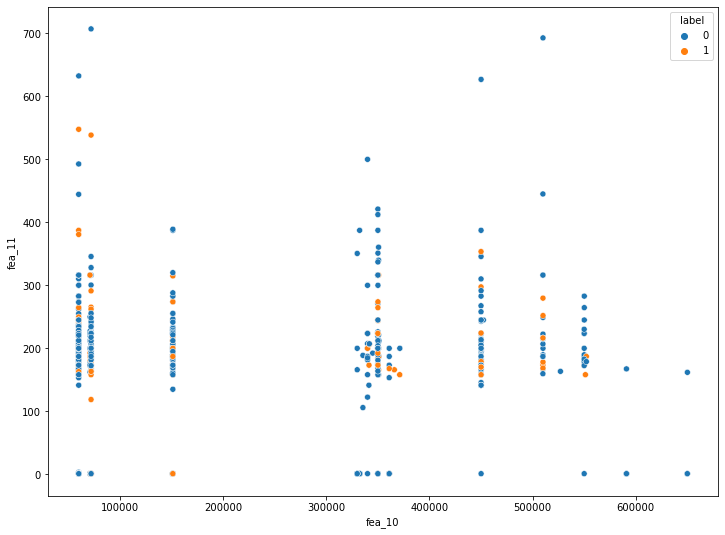

In [87]:
# Random Plot of 2 features to visualize the data imbalance for the Lavbel
plt.figure(figsize = (12,9))
sns.scatterplot(data = df_merge,
                y = 'fea_11',
                x = 'fea_10',
                hue = 'label')

# 2.0 Modelling without Over Sampling
___

In [88]:
X = df_merge.drop('label' , axis = 1)
y = df_merge['label']

print(f'Shape of X: {X.shape}')
print(f'Shape of y: {y.shape}')
print(y.value_counts(normalize=True))
print('---------------------------')


X_train , X_test , y_train , y_test = train_test_split(X, 
                                                       y, 
                                                       test_size=0.2,
                                                       stratify = y,
                                                       random_state=42)

print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of y_train: {X_test.shape}')
print(y_train.value_counts(normalize=True))

Shape of X: (1125, 17)
Shape of y: (1125,)
0    0.8
1    0.2
Name: label, dtype: float64
---------------------------
Shape of X_train: (900, 17)
Shape of y_train: (225, 17)
0    0.8
1    0.2
Name: label, dtype: float64


In [89]:
model_1_lr = LogisticRegression()

lr_params = {'penalty' : ['l1' , 'l2'],
             'C' : np.linspace(0.0001,0.1,200),
             'solver' : ['liblinear'],
             'max_iter' : [100 , 500 , 1000 , 5000]}

In [90]:
model_1_gs = GridSearchCV(LogisticRegression(random_state=42),
                          lr_params,
                          cv = 5,
                          verbose = False)

model_1_gs.fit(X_train , y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
             param_grid={'C': array([0.0001    , 0.00060201, 0.00110402, 0.00160603, 0.00210804,
       0.00261005, 0.00311206, 0.00361407, 0.00411608, 0.00461809,
       0.0051201 , 0.00562211, 0.00612412, 0.00662613, 0.00712814,
       0.00763015, 0.00813216, 0.00863417, 0.00913618, 0.00963819,
       0.0101402 , 0.01064221, 0.01114422, 0.01164623, 0.012...
       0.08795176, 0.08845377, 0.08895578, 0.08945779, 0.0899598 ,
       0.09046181, 0.09096382, 0.09146583, 0.09196784, 0.09246985,
       0.09297186, 0.09347387, 0.09397588, 0.09447789, 0.0949799 ,
       0.09548191, 0.09598392, 0.09648593, 0.09698794, 0.09748995,
       0.09799196, 0.09849397, 0.09899598, 0.09949799, 0.1       ]),
                         'max_iter': [100, 500, 1000, 5000],
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
             verbose=False)

In [91]:
model_1_gs.best_params_

{'C': 0.0001, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}

In [92]:
model_1_lr = LogisticRegression(solver = 'liblinear' , penalty = 'l1' , C = 0.0001)
model_1_lr.fit(X_train , y_train)

LogisticRegression(C=0.0001, penalty='l1', solver='liblinear')

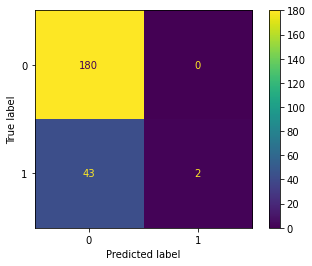

In [93]:
y_pred = model_1_lr.predict(X_test)
plot_confusion_matrix(model_1_lr , X_test , y_test);

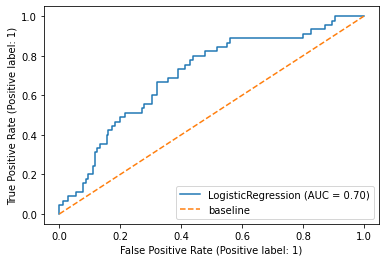

In [94]:
plot_roc_curve(model_1_lr, X_test, y_test)
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.legend();

In [95]:
result_1 = eval_classification(y_true = y_test , y_pred=y_pred)
result_1

{'Accuracy': 0.8088888888888889,
 'Precision': 1.0,
 'F1 Score': 0.0851063829787234,
 'Recall': 0.044444444444444446}

From the results , since the data is **unbalaced** at a ratio of 1:4 , it is easier for the model to just predict the majority. This give rise to 0 score for the f1 score.

# 3.0 Modelling with SMOTE
___

In [96]:
X = df_merge.drop('label' , axis = 1)
y = df_merge['label']

print(f'Shape of X: {X.shape}')
print(f'Shape of y: {y.shape}')
print(y.value_counts())
print('---------------------------')

smote = SMOTE(sampling_strategy='minority',
              random_state = 42)

X_sm, y_sm = smote.fit_resample(X = np.array(df_merge.drop('label' , axis = 1)),
                                y = np.array(df_merge['label']))

print(f'Shape of X_sm: {X_sm.shape}')
print(f'Shape of y_sm: {y_sm.shape}')
print(np.bincount(y_sm))
print('---------------------------')


X_train , X_test , y_train , y_test = train_test_split(X_sm , 
                                                       y_sm , 
                                                       test_size=0.2,
                                                       stratify = y_sm,
                                                       random_state=42)

print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of y_train: {X_test.shape}')

Shape of X: (1125, 17)
Shape of y: (1125,)
0    900
1    225
Name: label, dtype: int64
---------------------------
Shape of X_sm: (1800, 17)
Shape of y_sm: (1800,)
[900 900]
---------------------------
Shape of X_train: (1440, 17)
Shape of y_train: (360, 17)


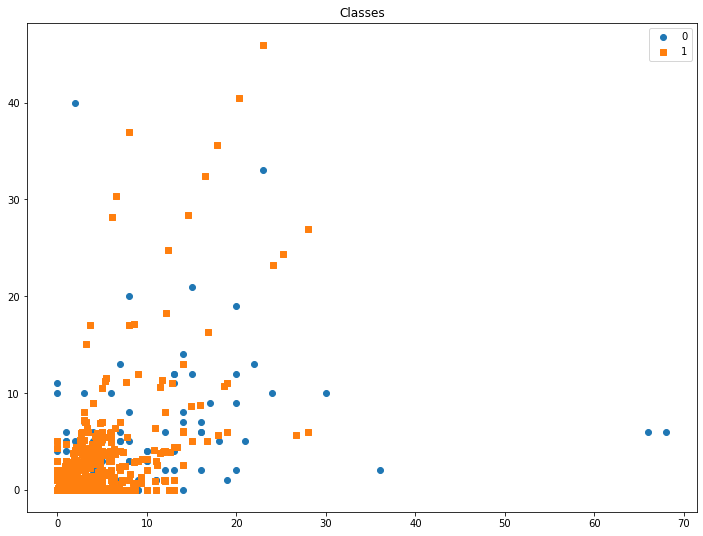

In [97]:
plt.figure(figsize = (12,9))
plot_2d_space(X_sm , y_sm)

In [98]:
model_2_lr = LogisticRegression()

lr_params = {'penalty' : ['l1' , 'l2'],
             'C' : np.linspace(0.0001,0.1,200),
             'solver' : ['liblinear']}

In [99]:
model_2_gs = GridSearchCV(LogisticRegression(random_state=42),
                          lr_params,
                          cv = 5,
                          verbose = False)

model_2_gs.fit(X_train , y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
             param_grid={'C': array([0.0001    , 0.00060201, 0.00110402, 0.00160603, 0.00210804,
       0.00261005, 0.00311206, 0.00361407, 0.00411608, 0.00461809,
       0.0051201 , 0.00562211, 0.00612412, 0.00662613, 0.00712814,
       0.00763015, 0.00813216, 0.00863417, 0.00913618, 0.00963819,
       0.0101402 , 0.01064221, 0.01114422, 0.01164623, 0.012...
       0.08544171, 0.08594372, 0.08644573, 0.08694774, 0.08744975,
       0.08795176, 0.08845377, 0.08895578, 0.08945779, 0.0899598 ,
       0.09046181, 0.09096382, 0.09146583, 0.09196784, 0.09246985,
       0.09297186, 0.09347387, 0.09397588, 0.09447789, 0.0949799 ,
       0.09548191, 0.09598392, 0.09648593, 0.09698794, 0.09748995,
       0.09799196, 0.09849397, 0.09899598, 0.09949799, 0.1       ]),
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
             verbose=False)

In [100]:
model_2_gs.best_params_

{'C': 0.06536130653266332, 'penalty': 'l1', 'solver': 'liblinear'}

In [101]:
model_2_lr = LogisticRegression(solver = 'liblinear' , penalty = 'l1' , C = 0.065313)
model_2_lr.fit(X_train , y_train)

LogisticRegression(C=0.065313, penalty='l1', solver='liblinear')

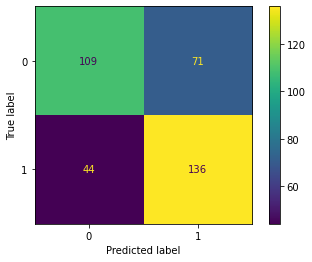

In [102]:
y_pred = model_2_lr.predict(X_test)
plot_confusion_matrix(model_2_lr , X_test , y_test)

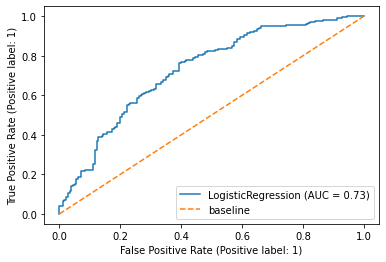

In [103]:
plot_roc_curve(model_2_lr, X_test, y_test)
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.legend();

In [104]:
result_2 = eval_classification(y_true = y_test , y_pred=y_pred)
result_2

{'Accuracy': 0.6805555555555556,
 'Precision': 0.6570048309178744,
 'F1 Score': 0.702842377260982,
 'Recall': 0.7555555555555555}

# 4.0 Modelling with Random Under Sampling
___

In [105]:
from imblearn.under_sampling import RandomUnderSampler

In [106]:
X = df_merge.drop('label' , axis = 1)
y = df_merge['label']

print(f'Shape of X: {X.shape}')
print(f'Shape of y: {y.shape}')
print(y.value_counts())
print('---------------------------')

rus = RandomUnderSampler(sampling_strategy='majority',
                          random_state = 42)

X_rus, y_rus = rus.fit_resample(X = np.array(df_merge.drop('label' , axis = 1)),
                                y = np.array(df_merge['label']))

print(f'Shape of X_rus: {X_rus.shape}')
print(f'Shape of y_rus: {y_rus.shape}')
print(np.bincount(y_rus))
print('---------------------------')


X_train , X_test , y_train , y_test = train_test_split(X_rus , 
                                                       y_rus , 
                                                       test_size=0.2,
                                                       stratify = y_rus,
                                                       random_state=42)

print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of y_train: {X_test.shape}')

Shape of X: (1125, 17)
Shape of y: (1125,)
0    900
1    225
Name: label, dtype: int64
---------------------------
Shape of X_rus: (450, 17)
Shape of y_rus: (450,)
[225 225]
---------------------------
Shape of X_train: (360, 17)
Shape of y_train: (90, 17)


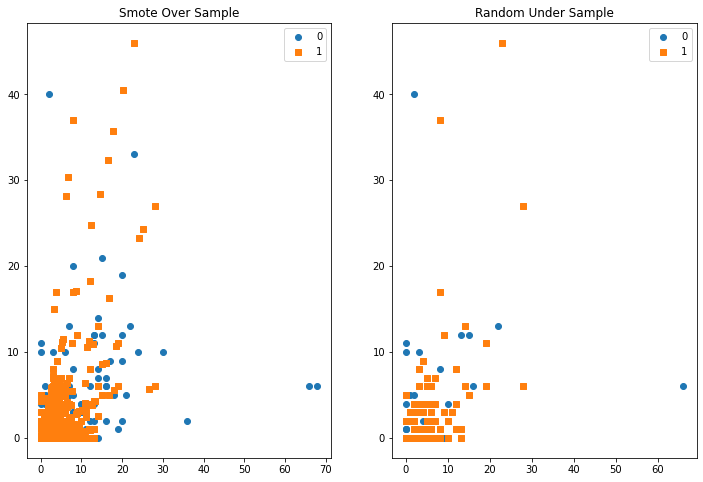

In [107]:
plt.figure(figsize = (12,8))

plt.subplot(1,2,1)
plot_2d_space(X_sm , y_sm , label = 'Smote Over Sample')

plt.subplot(1,2,2)
plot_2d_space(X_rus , y_rus , label = 'Random Under Sample')

In [108]:
model_3_lr = LogisticRegression()

lr_params = {'penalty' : ['l1' , 'l2'],
             'C' : np.linspace(0.0001,0.1,200),
             'solver' : ['liblinear']}

model_3_gs = GridSearchCV(LogisticRegression(random_state=42),
                          lr_params,
                          cv = 5,
                          verbose = False)

model_3_gs.fit(X_train , y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
             param_grid={'C': array([0.0001    , 0.00060201, 0.00110402, 0.00160603, 0.00210804,
       0.00261005, 0.00311206, 0.00361407, 0.00411608, 0.00461809,
       0.0051201 , 0.00562211, 0.00612412, 0.00662613, 0.00712814,
       0.00763015, 0.00813216, 0.00863417, 0.00913618, 0.00963819,
       0.0101402 , 0.01064221, 0.01114422, 0.01164623, 0.012...
       0.08544171, 0.08594372, 0.08644573, 0.08694774, 0.08744975,
       0.08795176, 0.08845377, 0.08895578, 0.08945779, 0.0899598 ,
       0.09046181, 0.09096382, 0.09146583, 0.09196784, 0.09246985,
       0.09297186, 0.09347387, 0.09397588, 0.09447789, 0.0949799 ,
       0.09548191, 0.09598392, 0.09648593, 0.09698794, 0.09748995,
       0.09799196, 0.09849397, 0.09899598, 0.09949799, 0.1       ]),
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
             verbose=False)

In [109]:
model_3_gs.best_params_

{'C': 0.049798994974874375, 'penalty': 'l1', 'solver': 'liblinear'}

In [110]:
model_3_lr = LogisticRegression(C = 0.0497989,
                                penalty = 'l1',
                                solver = 'liblinear',
                                random_state=42)

model_3_lr.fit(X_train , y_train)

LogisticRegression(C=0.0497989, penalty='l1', random_state=42,
                   solver='liblinear')

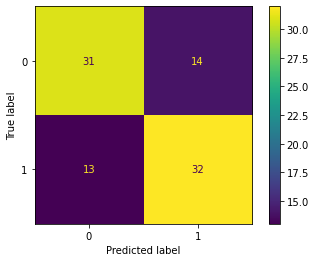

In [111]:
y_pred = model_3_lr.predict(X_test)

plot_confusion_matrix(model_3_lr , X_test , y_test)

In [112]:
result_3 = eval_classification(y_true = y_test , y_pred=y_pred)
result_3

{'Accuracy': 0.7,
 'Precision': 0.6956521739130435,
 'F1 Score': 0.7032967032967032,
 'Recall': 0.7111111111111111}

# 5.0 Modelling with Over Sampling with varying minority Size
___

In [113]:
%%time
X = df_merge.drop('label' , axis = 1)
y = df_merge['label']


df = pd.DataFrame()

for i in np.arange(0.4 , 1 , 0.1):
    smote = SMOTE(sampling_strategy= i,
                              random_state = 42)

    X_sm, y_sm = smote.fit_resample(X = np.array(df_merge.drop('label' , axis = 1)),
                                 y = np.array(df_merge['label']))

    X_train , X_test , y_train , y_test = train_test_split(X_sm , 
                                                           y_sm , 
                                                           test_size=0.2,
                                                           stratify = y_sm,
                                                           random_state=42)
    model_4_lr = LogisticRegression()

    lr_params = {'penalty' : ['l1' , 'l2'],
                 'C' : np.linspace(0.0001,0.1,200),
                 'solver' : ['liblinear']}

    model_4_gs = GridSearchCV(LogisticRegression(random_state=42),
                              lr_params,
                              cv = 5,
                              verbose = False)

    model_4_gs.fit(X_train , y_train)

    y_pred = model_4_gs.predict(X_test)
    
    results = eval_classification(y_true = y_test , y_pred=y_pred)
    df = df.append(results , ignore_index=True)

Wall time: 1min 17s


In [114]:
df

,Accuracy,F1 Score,Precision,Recall
0,0.730159,0.105263,1.000000,0.055556
1,0.674074,0.200000,0.550000,0.122222
2,0.677083,0.436364,0.631579,0.333333
3,0.663399,0.497561,0.645570,0.404762
4,0.660494,0.598540,0.630769,0.569444
5,0.646199,0.636637,0.619883,0.654321


# 6.0 Modelling with Hybrid Oversample and UnderSample
___

In [115]:
from imblearn.combine import SMOTEENN

In [116]:


X = df_merge.drop('label' , axis = 1)
y = df_merge['label']

print(f'Shape of X: {X.shape}')
print(f'Shape of y: {y.shape}')
print(y.value_counts())
print('---------------------------')

smenn = SMOTEENN(random_state=42)

X_smenn, y_smenn = smenn.fit_resample(X = np.array(df_merge.drop('label' , axis = 1)),
                                      y = np.array(df_merge['label']))

print(f'Shape of X_smenn: {X_smenn.shape}')
print(f'Shape of y_smenn: {y_smenn.shape}')
print(np.bincount(y_smenn))
print('---------------------------')


X_train , X_test , y_train , y_test = train_test_split(X_smenn , 
                                                       y_smenn , 
                                                       test_size=0.2,
                                                       stratify = y_smenn,
                                                       random_state=42)

print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of y_train: {X_test.shape}')

Shape of X: (1125, 17)
Shape of y: (1125,)
0    900
1    225
Name: label, dtype: int64
---------------------------
Shape of X_smenn: (930, 17)
Shape of y_smenn: (930,)
[398 532]
---------------------------
Shape of X_train: (744, 17)
Shape of y_train: (186, 17)


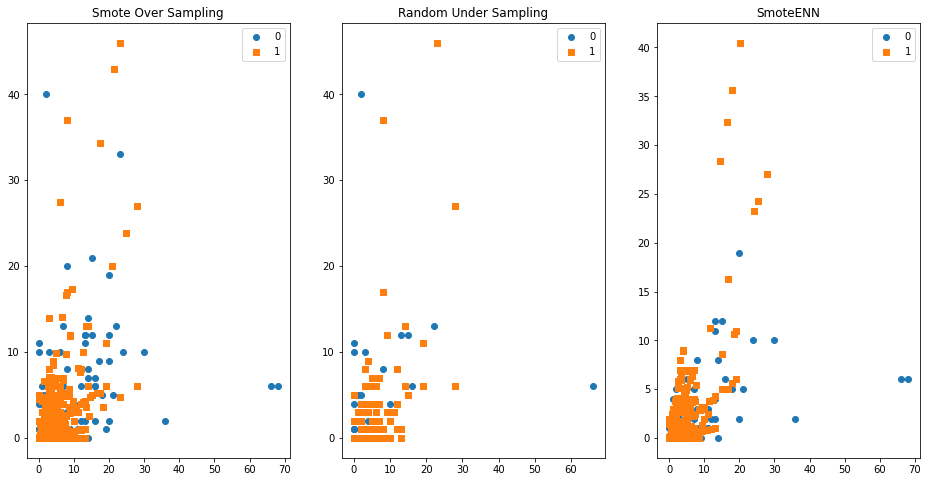

In [117]:
plt.figure(figsize = (16,8))

plt.subplot(1,3,1)
plot_2d_space(X_sm , y_sm , label = 'Smote Over Sampling')

plt.subplot(1,3,2)
plot_2d_space(X_rus , y_rus , label = 'Random Under Sampling')

plt.subplot(1,3,3)
plot_2d_space(X_smenn , y_smenn , label = 'SmoteENN')

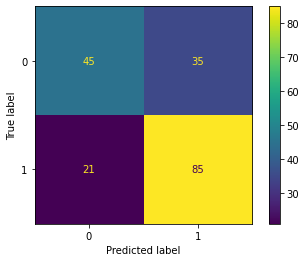

In [118]:
model_5_lr = LogisticRegression()

lr_params = {'penalty' : ['l1' , 'l2'],
             'C' : np.linspace(0.0001,0.1,200),
             'solver' : ['liblinear']}

model_5_gs = GridSearchCV(LogisticRegression(random_state=42),
                          lr_params,
                          cv = 5,
                          verbose = False)

model_5_gs.fit(X_train , y_train)

y_pred = model_5_gs.predict(X_test)

plot_confusion_matrix(model_5_gs , X_test , y_test)

In [119]:
result_5 = eval_classification(y_true = y_test , y_pred=y_pred)
result_5

{'Accuracy': 0.6989247311827957,
 'Precision': 0.7083333333333334,
 'F1 Score': 0.7522123893805309,
 'Recall': 0.8018867924528302}

# Summary result
___

In [120]:
result = {'Baseline' : result_1,
          'Smote': result_2,
          'RUS' : result_3,
          'SmoteENN' : result_5}

df = pd.DataFrame.from_dict(result).T
df

,Accuracy,Precision,F1 Score,Recall
Baseline,0.808889,1.000000,0.085106,0.044444
Smote,0.680556,0.657005,0.702842,0.755556
RUS,0.700000,0.695652,0.703297,0.711111
SmoteENN,0.698925,0.708333,0.752212,0.801887
